# Aperture distribution
The purpose of this notebook is to show all sub-functions necessary to compute the aperture distribution in a single-dish radio telescope (or emitting antenna). The aperture distribution, $\underline{E_\text{a}}(x, y)$ is a 2-dimensional complex distribution which depends on,

$$\underline{E_\text{a}}(x, y) = B(x, y) \cdot E_\text{a}(x, y) \cdot \mathrm e^{\mathrm{i}\varphi(x, y)}, $$

where $E_\text{a}(x, y)$ is the illumination function (receiver property). $B(x, y)$ is the telescope's truncation or blockage made by its structure and shade effects. $\varphi(x, y)$ is the phase error (or aperture phase distribution), and it can be expressed in terms of the wavefront (aberration) distribution, $\varphi(x, y) = 2\pi W(x, y)$.


In [37]:
# Adjustin notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [38]:
# importing math and plot packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from scipy.constants import golden  # Golden ratio
from astropy.io import ascii  # to read examples
from pyoof import telgeometry, aperture, cart2pol, wavevector2degrees

# Plotting parameters, to make it nice :) 
matplotlib.rcParams['figure.figsize'] = (golden * 7, 7)
matplotlib.rcParams['figure.subplot.wspace'] = 0.5
matplotlib.rcParams['figure.subplot.left'] = 0.1
matplotlib.rcParams['figure.subplot.bottom'] = 0.2
matplotlib.rcParams['figure.subplot.right'] = 1
matplotlib.rcParams['figure.subplot.top'] = 0.85
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.titlesize'] = 15

### Blockage distribution
The blockage or the telecope geometry, $B(x, y)$, is specific for every telescope. In general, its structure is given by a main dish and a sub-reflector dish (aperture antennas). From the out-of-focus (OOF) holography study, it has been seen that the structure plays an important role in the least squares minimization beam fit procedure and it is suggested to make it as accurate as possible.
Below is the case for a generic telescope configuration and for the Effelsberg telescope.

In [39]:
pr = 50  # primary relfector m
sr = 3.25  # sub-reflector m

box_size = pr * 5
resolution = 2 ** 12

x = np.linspace(-box_size, box_size, resolution)
y = x  # squared mesh
x_grid, y_grid = np.meshgrid(x, y)

# Let's look up at some of the basic parameters of a manual configuration
help(telgeometry.block_manual)

Help on function block_manual in module pyoof.telgeometry.telgeometry:

block_manual(pr, sr, a, L)
    Truncation for the aperture (amplitude) distribution, manual set up for
    the primary radius (pr), sub-reflector radius (sr), half-width of a
    support leg (a) and length of the support leg (L) measured from the edge
    of the sr. It has been considered 4 support legs. To exclude sr, a or L
    set them to zero.
    
    Parameters
    ----------
    pr : float
        Primary reflector radius.
    sr : float
        Sub-reflector radius.
    a : float
        Half-width of a support leg.
    L : float
        Length of a support leg, measured from the edge of the sub-reflector
        towards its end.
    
    Returns
    -------
    block_func : function
        It returns the function block_func(x, y), which depends only on the
        grid values. For arguments see block_effelsberg.



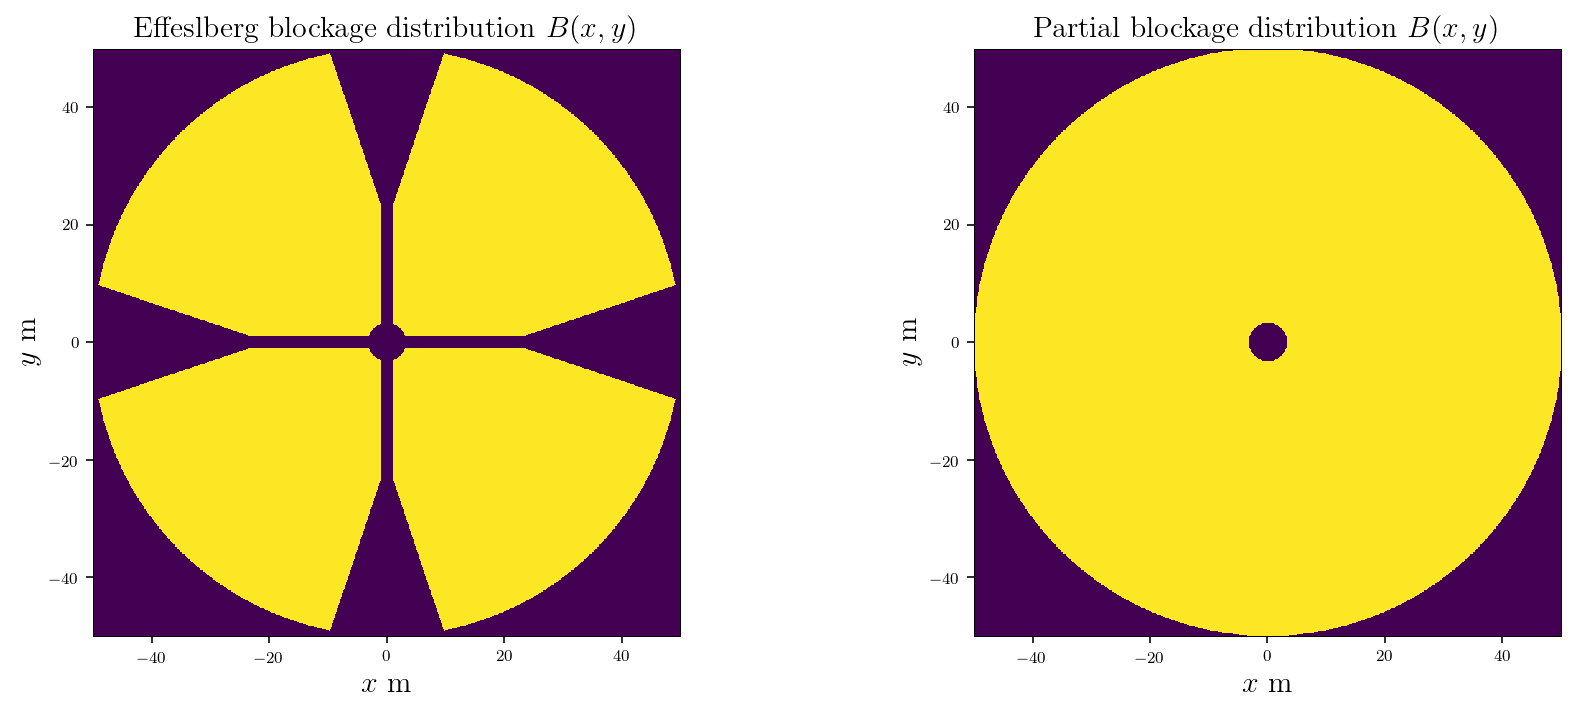

In [40]:
# Testing the blockage functions
block_partial = telgeometry.block_manual(pr=pr, sr=sr, a=0, L=0)(x=x_grid, y=y_grid)
block_effelsberg = telgeometry.block_effelsberg(x=x_grid, y=y_grid)

fig, ax = plt.subplots(ncols=2)
extent = [-box_size, box_size, -box_size, box_size]
    
ax[0].set_title('Effeslberg blockage distribution $B(x, y)$')
ax[0].imshow(block_effelsberg, extent=extent, origin='lower')

ax[1].set_title('Partial blockage distribution $B(x, y)$')
ax[1].imshow(block_partial, extent=extent, origin='lower')

for _ax in ax:
    _ax.set_xlabel('$x$ m')
    _ax.set_ylabel('$y$ m')
    _ax.grid('off')
    _ax.set_xlim(-50, 50)
    _ax.set_ylim(-50, 50)

### Illumination function
The illumination function, $E_\text{a}(x, y)$, is also a 2-dimensional grid, it is usually presented as a 1-dim function in books to compare between several types. There are several important parameters in an illumination functions, its offset $(x_0, y_0)$, amplitud, taper in dB and its order. The most importat of them is the taper, which defines the strength of the received signal at the edges.

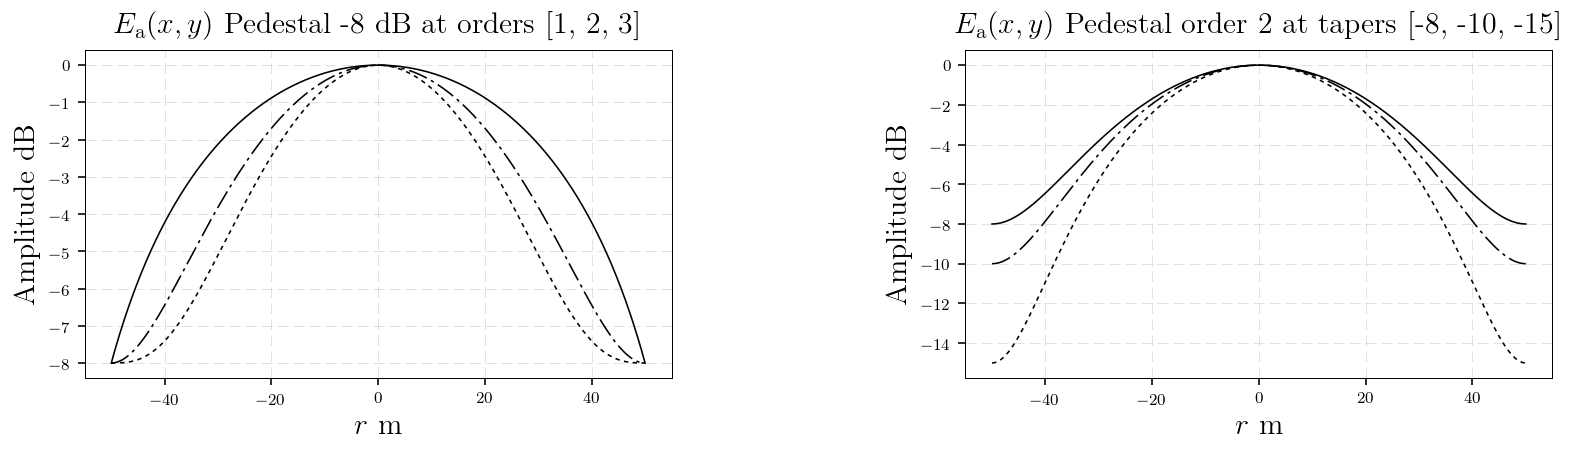

In [41]:
plt.close(fig)  # to not have mixed plots
# importing the illumination functions
fig, ax = plt.subplots(ncols=2, figsize=(golden * 7, 7/2))

orders = [1, 2, 3]
tapers = [-8, -10, -15]

x_linear = np.linspace(-pr, pr, 1e3)
linestyle = ['-', '-.', ':']

for order, taper, _linestyle in zip(orders, tapers, linestyle):
    _illum_order = aperture.illum_pedestal(
        x=x_linear, y=0, 
        I_coeff=[1, -8, 0, 0],
        pr=pr, q=order
        )
    
    __illum_taper = aperture.illum_pedestal(
        x=x_linear, y=0,
        I_coeff=[1, taper, 0, 0],
        pr=pr, q=2
        )
    
    ax[0].plot(x_linear, 20 * np.log10(_illum_order), linestyle=_linestyle, c='k')
    ax[0].set_title('$E_{\\mathrm{a}}(x, y)$ Pedestal -8 dB at orders ' + str(orders))

    ax[1].set_title('$E_{\\mathrm{a}}(x, y)$ Pedestal order 2 at tapers ' + str(tapers))
    ax[1].plot(x_linear, 20 * np.log10(__illum_taper), linestyle=_linestyle, c='k')

for _ax in ax:
    _ax.set_xlabel('$r$ m')
    _ax.set_ylabel('Amplitude dB')

The application of the illumination to the blockage structure is straight forward, just a simple multiplication.

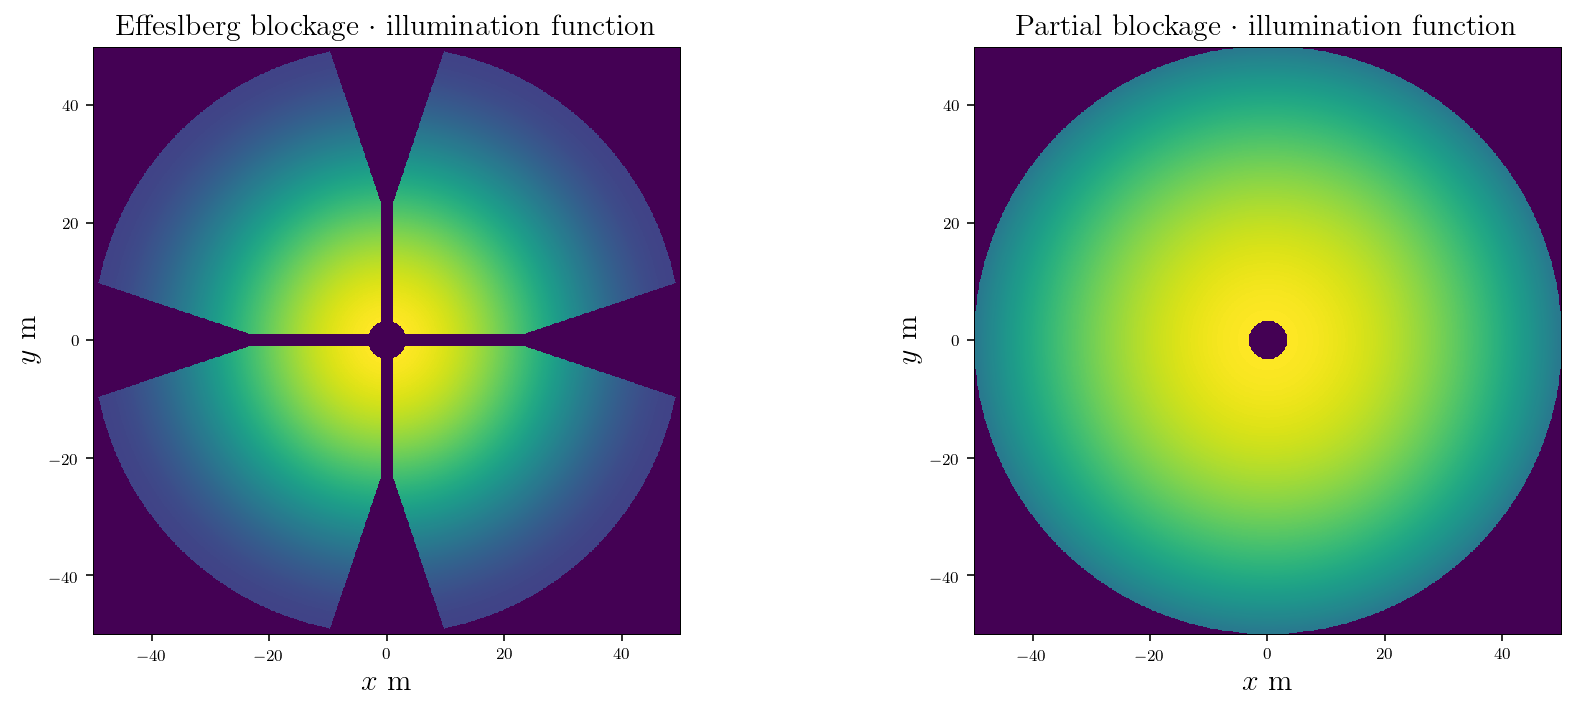

In [42]:
# Defining the illumination function for the Effelsberg telecope
illum_effeslberg = aperture.illum_pedestal(
    x=x_grid, y=y_grid, I_coeff=[1, -14, 0, 0], pr=pr, q=2
    )
illum_other = aperture.illum_pedestal(
    x=x_grid, y=y_grid, I_coeff=[1, -8, 0, 0], pr=pr, q=1
    )
aperture_amplitude_effelsberg = block_effelsberg * illum_effeslberg
aperture_amplitude_other = block_partial * illum_other

plt.close(fig)
fig, ax = plt.subplots(ncols=2)

ax[0].set_title('Effeslberg blockage $\cdot$ illumination function')
ax[0].imshow(aperture_amplitude_effelsberg, extent=extent)

ax[1].set_title('Partial blockage $\cdot$ illumination function')
ax[1].imshow(aperture_amplitude_other, extent=extent)

for _ax in ax:
    _ax.grid('off')
    _ax.set_xlabel('$x$ m')
    _ax.set_ylabel('$y$ m')
    _ax.set_xlim(-pr, pr)
    _ax.set_ylim(-pr, pr)

### Aperture phase distribution
To understand the relation between the phase error and the wavefront (aberration) distribution, first take a look at the `zernike.ipynb` notebook. The notebook explains the formulation of the Zernike cirlce polynomials and their coefficients. 
In general terms, the $\varphi(x, y)$ distribution is the wavefront (aberration) distribution, $W(x, y)$, in radians, and it belongs to the deformation (and other effects) of the primary dish. The wavefront-phase relation is given by:

$$\varphi(x, y) = 2\pi W(x, y)=\sum_{n,\ell}K_{n\ell}U^\ell_n(\varrho,\vartheta).$$

To compute it, a decomposition has to be done in terms of a convinient set of polynomials. The Zernike circle polynomials, $U^\ell_n(\varrho, \vartheta)$, and their respective multiplied coefficients, $K_{n\ell}$. Using this mathematical tool, the aperture phase distribution can be calculated. Using `np.random.normal` we generate random Zernike circle coefficients.

K_coeff:  [ 0.07173507  0.09227757  0.10116226 -0.16675965  0.0336253  -0.01808519
  0.02017293  0.30349973  0.02325743 -0.02154583 -0.14875837  0.01751482
  0.07725037  0.1020367   0.10768854 -0.11728814 -0.03938079  0.10127339
  0.03789372 -0.06779264  0.08854737]


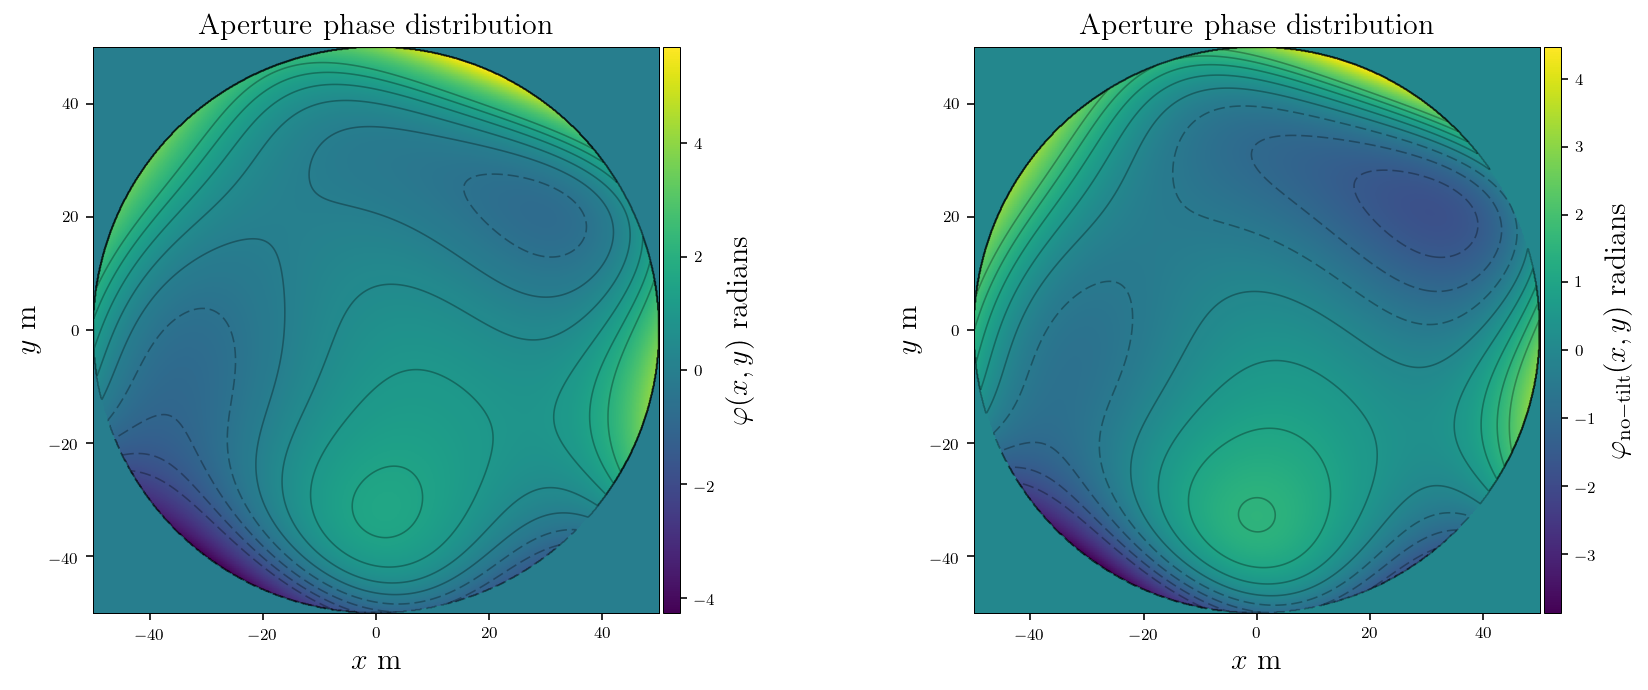

In [47]:
# Zernike cirlce polynomial coefficients
n = 5  # order polynomial
N_K_coeff = (n + 1) * (n + 2) // 2  # max polynomial number
K_coeff = np.random.normal(0., .1, N_K_coeff)
print('K_coeff: ', K_coeff)

K_coeff_notilt = K_coeff.copy()  # removing tilt terms
for i in range(3):
    K_coeff_notilt[i] = 0

r, t = cart2pol(x_grid, y_grid)
r_norm = r / pr  # radii normalization to conserve orthogonality

# Wavefront (aberration) distribution (no-tilt)
W_notilt = aperture.wavefront(rho=r_norm, theta=t, K_coeff=K_coeff_notilt)
W_notilt[x_grid ** 2 + y_grid ** 2 > pr ** 2] = 0
phi_notilt = W_notilt * 2 * np.pi  # aperture phase distribution

# Wavefront (aberration) distribution
W = aperture.wavefront(rho=r_norm, theta=t, K_coeff=K_coeff)
W[x_grid ** 2 + y_grid ** 2 > pr ** 2] = 0
phi = W * 2 * np.pi  # aperture phase distribution

levels = np.linspace(-2, 2, 9)  # half-radian increase
cbtitle = ['$\\varphi(x, y)$ radians', '$\\varphi_\mathrm{no-tilt}(x, y)$ radians']

plt.close(fig)
fig, ax = plt.subplots(ncols=2)
for _phi, i, _cbtitle in zip([phi, phi_notilt], range(2), cbtitle): 
    im = ax[i].imshow(_phi, extent=extent)
    ax[i].contour(x, y, _phi, levels=levels, colors='k', alpha=0.3)

    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="3%", pad=0.03)
    cb = fig.colorbar(im, cax=cax)
    cb.ax.set_ylabel(_cbtitle)
    
    ax[i].set_title('Aperture phase distribution')
    ax[i].set_ylabel('$y$ m')
    ax[i].set_xlabel('$x$ m')
    ax[i].set_xlim(-pr, pr)
    ax[i].set_ylim(-pr, pr)
    ax[i].grid('off')

After the aperture phase distribution, $\varphi(x, y)$, is computed the complete (and complex) aperture distribution, $\underline{E_\text{a}}(x, y)$, is easily obtained, by simply using the same initial relation,
$$\underline{E_\text{a}}(x, y) = B(x, y) \cdot E_\text{a}(x, y) \cdot \mathrm e^{\mathrm{i}\sum_{n,\ell}K_{n\ell}U^\ell_n(\varrho,\vartheta)}.$$

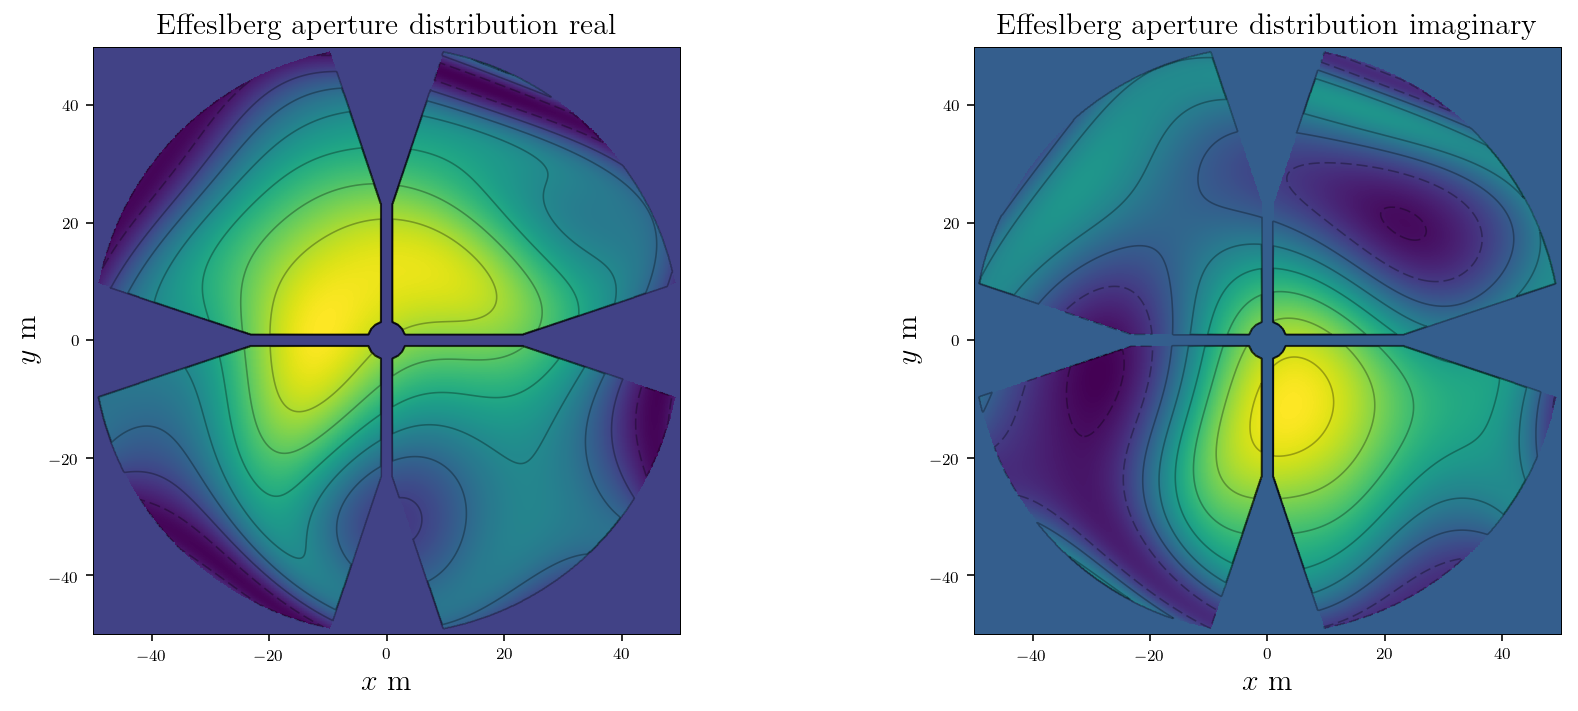

In [48]:
# Aperture distribution
# the tilt terms are required for the complete aperture distribution
aperture_effelsberg = aperture_amplitude_effelsberg * np.exp(1j * phi)

plt.close(fig)
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(aperture_effelsberg.real, extent=extent)
ax[0].contour(x_grid, y_grid, aperture_effelsberg.real, level=5, colors='k', alpha=0.3)
ax[0].set_title('Effeslberg aperture distribution real')

ax[1].imshow(aperture_effelsberg.imag, extent=extent)
ax[1].contour(x_grid, y_grid, aperture_effelsberg.imag, level=5, colors='k', alpha=0.3)
ax[1].set_title('Effeslberg aperture distribution imaginary')

for _ax in ax:
    _ax.grid('off')
    _ax.set_xlabel('$x$ m')
    _ax.set_ylabel('$y$ m')
    _ax.set_xlim(-pr, pr)
    _ax.set_ylim(-pr, pr)

The above result is the aperture distribution, $\underline{E_\text{a}}(x, y)$, model in the telescope's primary dish. Once it is computed is possible to apply the Fourier Transform (2-dimensions) to it and find the power pattern (or beam map), $P(u, v)$.

### Optical path difference function
The observed quantity in a radio telescope is the power pattern, beam or PSF (optical case). The power pattern, $P(u, v)$, is a function which only depends on intensity and it can be realted to the aperture distribution, $\underline{E_\text{a}}(x, y)$, through the Fourier operator. The relation follows,

$$   P(u, v) =  \left| \mathcal F\left[\underline{E_\text{a}}(x, y)\right] \right|^2  = \left | \iint\limits_{S_\text{a}} \underline{E_\text{a}}(x',y') \cdot \mathrm{e}^{-\mathrm{i}2\pi(x'u+y'v)}\,\mathrm{d} S' \right|^{\, 2}. $$

Where $S_\text{a}$ represent the aperture plane area of an aperture antenna. It is important to notice that if it is only known the power pattern, it is not possible to obtain the aperture distribution. The norm of a complex number makes the problem degenerated.

To solve this under-determined problem holography is applied. Holography is, in simple words, the transformation from the power pattern to the aperture distribution, and there exist several types for different situations. here we will be dealing with the out-of-focus (OOF) holography. The OOF holography adds two extra power pattern measurements by defocusing the telescope; this is by adding a radial offset to the sub-reflector. The radial offset, $d_z$, can be related to the phase error through an optical path difference term in addition to the current aperture phase distribution. The optical path difference, $\delta(x, y, d_z)$, is a function which only depends on the telescope geometry. It follows that the new phase error in the aperture distribution becomes,

$$\varphi'(x, y) = \varphi(x, y) + \frac{2\pi}{\lambda}\delta(x, y;d_z).$$

Where the function, $\delta(x, y;d_z)$, is known. The optical path difference, $\delta(x, y;d_z)$, depends on the radial offset, known a priori, adding this extra term to the phase error breaks the degeneracy.

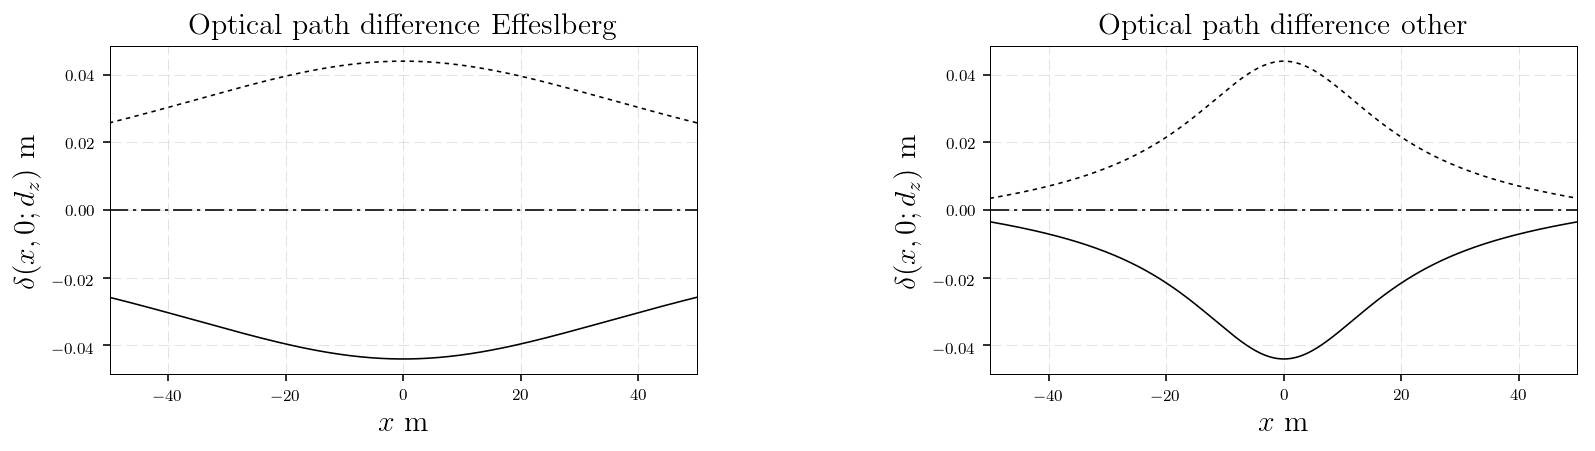

In [49]:
# Following the same example as before, three observations
# with a radial offset of -0.025, 0, 0.025 m in the sub-reflector.
d_z = np.array([-0.022, 0, 0.022])  # m

plt.close(fig)  # to not have mixed plots
fig, ax = plt.subplots(ncols=2, figsize=(golden * 7, 7/2))

for i in range(3):
    delta = telgeometry.opd_effelsberg(x=x, y=0, d_z=d_z[i])
    ax[0].plot(x, delta, linestyle=linestyle[i], c='k')

# see documentation for Fp and F
for i in range(3):
    delta = telgeometry.opd_manual(Fp=10, F=100)(x=x, y=0, d_z=d_z[i])
    ax[1].plot(x, delta, linestyle=linestyle[i], c='k')

ax[0].set_title('Optical path difference Effeslberg')
ax[1].set_title('Optical path difference other')
for _ax in ax:
    _ax.set_xlabel('$x$ m')
    _ax.set_ylabel('$\delta(x, 0;d_z)$ m')
    _ax.set_xlim(-pr, pr)

plt.show()

For the $d_z=0$ case, $\delta(x, y;0)=0$, there will be no change in the optics. Adding the new phase error, $\varphi'(x, y)$, to the aperture distribution, $\underline{E_\text{a}}(x, y)$, will generate a slight change in the final distribution, but meaningful to break the degeneracy. On the oposite side, when the power pattern is obtained from the aperture distribution, there will be a noticeable difference in the in-focus and out-of-focus maps.

### Power pattern
To compute the power pattern, we simply use the Fourier Transform, but now for every offset. This means that the phase error that needs to be used is $\varphi'(x, y)$, where the aperture distribution is,

$$    \underline{E_\text{a}}(x, y) = B(x, y) \cdot E_\text{a}(x, y) \cdot \mathrm e^{\mathrm{i}\varphi'(x, y)} $$

and the power pattern, $P(u, v) =  \left| \mathcal F\left[\underline{E_\text{a}}(x, y)\right] \right|^2$.

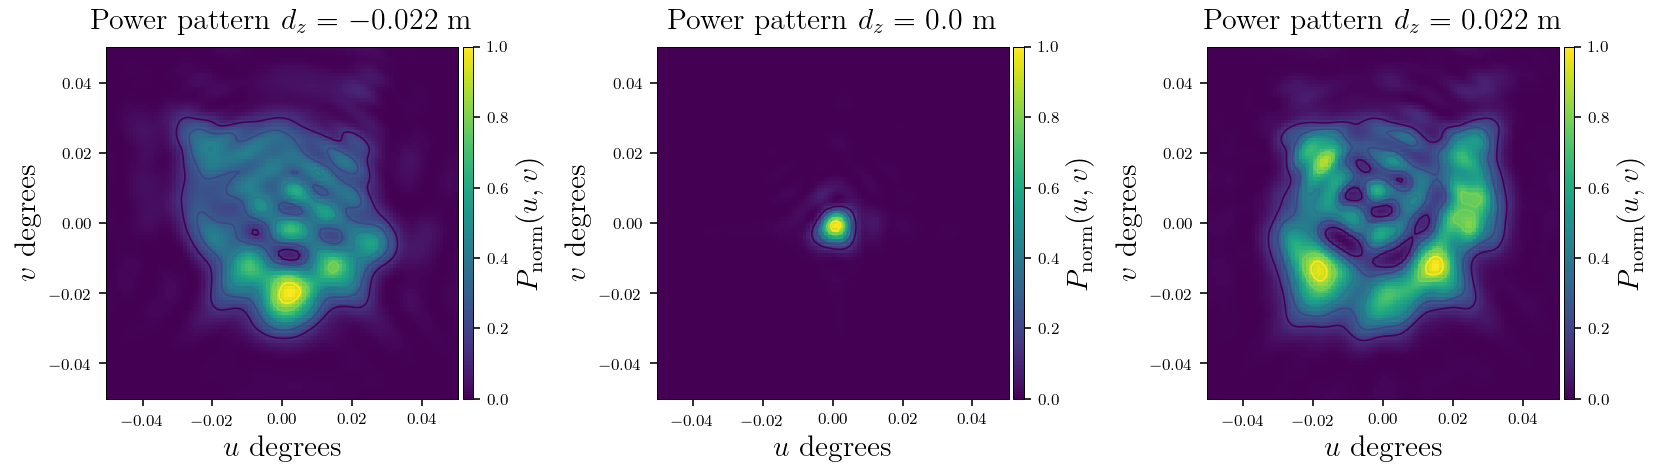

In [50]:
# Final complete example for the Effelsberg radio telescope

# To transform the path difference to radians
wavel = 0.009  # m. Observation wavelength

fig, ax = plt.subplots(ncols=3)

for i in range(3):
    # adding the extra term to the phase, the optical path length
    delta = telgeometry.opd_effelsberg(x=x_grid, y=y_grid, d_z=d_z[i])
    phi_prime = delta * 2 * np.pi / wavel + phi
    aperture_effelsberg = aperture_amplitude_effelsberg * np.exp(1j * phi_prime)

    # Computing the FFT in 2-dim
    F = np.fft.fft2(aperture_effelsberg)  # (field) radiation pattern
    F_shift = np.fft.fftshift(F)  # inversion in FFT2
    power_pattern = np.abs(F_shift) ** 2  # power pattern
    power_pattern_norm = power_pattern / power_pattern.max()

    # data resolution
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    # Calculation the wave-vectors and transforming them to degrees
    u, v = np.fft.fftfreq(x.size, dx), np.fft.fftfreq(y.size, dy)
    u_shift, v_shift = np.fft.fftshift(u), np.fft.fftshift(v)
    u_deg, v_deg = wavevector2degrees(u_shift, wavel), wavevector2degrees(v_shift, wavel)
    extent_uv = [u_deg.min(), u_deg.max(), v_deg.min(), v_deg.max()]

    # Beamwidth for plot limits
    bw = 70 * wavel / (2 * pr)  # Beamwidth degrees
    size_in_bw = 8 * bw
    plim_u = [-size_in_bw, size_in_bw]
    plim_v = [-size_in_bw, size_in_bw]
    
    im = ax[i].imshow(power_pattern_norm, extent=extent_uv)
    ax[i].contour(u_deg, v_deg, power_pattern_norm, level=5)
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="3%", pad=0.03)
    cb = fig.colorbar(im, cax=cax)
    cb.ax.set_ylabel('$P_{\\mathrm{norm}}(u, v)$')
    
    ax[i].set_xlim(*plim_u)
    ax[i].set_ylim(*plim_v)
    ax[i].grid('off')
    ax[i].set_xlabel('$u$ degrees')
    ax[i].set_ylabel('$v$ degrees')
    ax[i].set_title('Power pattern $d_z = ' + str(d_z[i]) + '$ m')

The above results have been normalized by its maximum, $P_\text{norm}(u, v) = \frac{P(u, v)}{P_\text{max}}$. What the `pyoof` package does is to reconstruct the power pattern from an aperture distribution model to then compare it to real observations and find the phase error maps for a single-dish radio telescope.